<a href="https://colab.research.google.com/github/abhinsuresh/MLTSA_ASuresh/blob/master/HW6/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART II of the Plassticc challenge homework: implement classification and clustring on the feature space you created in the previous homework
## This homework is split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Thursday 16th at noon, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models). Classifying astrophysical transients from photometry

In [0]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
mpl.style.use('default')

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [0]:
mkdir PLAsTiCC

In [0]:
cd PLAsTiCC

/content/gdrive/My Drive/PLAsTiCC


#Data Acquisition

In [0]:
!wget https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz

In [0]:
lcvs = pd.read_csv('plasticc_train_lightcurves.csv.gz')

In [0]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [0]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [0]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".\
      format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [0]:
!wget https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz

In [0]:
metadata = pd.read_csv("plasticc_train_metadata.csv.gz")
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')

In [0]:
print("The metadata dataset contains more information for each time series: \
      (time-series, columns)",
      metadata.shape)

The metadata dataset contains more information for each time series:       (time-series, columns) (7848, 26)


In [0]:
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

## Data vislization

In [0]:
# optional to run since we did it already in previous
# home work

#choose set of object_id
ls = [615, 84716, 169315, 243726, 325372, \
      9112192, 20222858, 31601139, 43018203, \
      54855653]

#colo codes form website
_passbands = OrderedDict([(0,'C4'), (1,'C2'), (2,'C3'),\
                          (3,'C1'), (4,'k'), (5,'C5')])

fig, axs = plt.subplots(10, 1, figsize=(5,40))
for i, ls_i in enumerate(ls):
  axs[i].set_title('object_id='+str(ls_i), loc = 'left',
                   size = 8)
  axs[i].set_xlabel('mjd')
  axs[i].set_ylabel('flux')

  for j in bands:
    axs[i].errorbar(lcvs.loc[lcvs['passband']== j, 'mjd'].\
                    where(lcvs.object_id==ls_i), 
                    lcvs.loc[lcvs['passband']== j, 'flux'].\
                    where(lcvs.object_id==ls_i), 
                    lcvs.loc[lcvs['passband']== j, 'flux_err'].\
                    where(lcvs.object_id==ls_i),
                    fmt = 'o', color = _passbands[j], ms = 3)

Figure 1: This plot shows the flux  corresponding to different bands against modified Julian days, along with errorbars for 10 different objects. Color codes (ultraviolet→'C0', green/blue→'C2', red→'C3', infrared→'C1', z→'k', y→'C5'). The peak in flux for various different objects on different days can be seen in the figure. for  object 84716 there is steep rise in flux and then a gradual decrease. Similar pattern is observed for several other objects.

# Part IIA: Feature Extraction

1. Extraction mean and standard deviation of the original lightcurve

In [0]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = means.rename({"flux": "mean"}, axis=1).\
                  merge(stds.rename({"flux": "std"}, axis=1), 
                        left_index=True, right_index=True)

2. Heigher order moments m1 and m2

In [0]:
from scipy import stats 
def m2_get(x):
    return stats.moment(x, moment = 2)
def m3_get(x):
    return stats.moment(x, moment = 3)
    
m2 = lcvs.groupby(["object_id", "passband"])["flux"].apply(m2_get)
m3 = lcvs.groupby(["object_id", "passband"])["flux"].apply(m3_get)

In [0]:
features = features.merge(pd.DataFrame(m2).rename({"flux":"m2"}, axis=1), 
                          left_index=True, right_index=True)
features = features.merge(pd.DataFrame(m2).rename({"flux":"m3"}, axis=1), 
                          left_index=True, right_index=True)

3. Max and Min values

In [0]:
maxs = lcvs.groupby(["object_id", "passband"])["flux"].max()
mins = lcvs.groupby(["object_id", "passband"])["flux"].min()

In [0]:
features = features.merge(pd.DataFrame(maxs).rename({"flux":"maxs"}, axis=1), 
                          left_index=True, right_index=True)
features = features.merge(pd.DataFrame(mins).rename({"flux":"mins"}, axis=1), 
                          left_index=True, right_index=True)

4. Normalizing the original lightcurve

In [0]:
# normalize each LC this is very slow. can you make  it faster?
def normed(df):
   return (df - df.mean())/df.std()
       
lcvs['fluxnormed'] = lcvs.groupby(["object_id", "passband"])[['flux']].\
                                  apply(normed)
lcvs['fluxerrnormed'] = lcvs.groupby(["object_id", "passband"])[['flux_err']].\
                                  apply(normed)

5. Extraction of median and line fit parameters from normalized lightcurve : giving the center of mass

In [0]:
median = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()
#stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
features = features.merge(median.rename({"fluxnormed": "median"}, axis=1), 
                        left_index=True, right_index=True)

6. Line fit parameters of normalized lightcurve

In [0]:
def slope(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars[0]
def intercept(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars[1]  

features['slope'] = lcvs.groupby(["object_id", "passband"]).\
                                      apply(slope).to_frame()
features['intercept'] = lcvs.groupby(["object_id", "passband"]).\
                                      apply(intercept).to_frame()

7. Quadratic fit parameters of the normalized lightcurve

In [0]:
from statsmodels.formula.api import ols
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    mod1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    mod2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = mod2.llf, mod1.llf, np.sign(mod2.params[1])
    return pars
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [0]:
ll1 = [x[0] for x in ols.values[:]]
ll2 = [x[1] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]

In [0]:
features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

In [0]:
features.head()

mean         std  ...        ll2  ll3
object_id passband                          ...                
615       0          -3.254554   83.944735  ... -88.218652 -1.0
          1        -385.699911  601.787302  ... -80.869998 -1.0
          2        -134.146566  455.121346  ... -80.109763 -1.0
          3        -121.103501  335.425053  ... -79.290039 -1.0
          4         -55.954592  291.803449  ... -78.480261 -1.0

[5 rows x 13 columns]

In [0]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [0]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


8. Adding features from metadata

In [0]:
allfeatures = allfeatures.merge(metadata[["object_id", "decl", "ddf_bool", \
                                          "hostgal_photoz",\
                                          "hostgal_photoz_err", "target"]], \
                                on=['object_id']).drop("object_id", axis=1)
allfeatures.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(0, mean)","(0, std)","(0, m2)","(0, m3)","(0, maxs)","(0, mins)","(0, median_x)","(0, median_y)","(0, slope)","(0, intercept)","(0, ll1)","(0, ll2)","(0, ll3)","(1, mean)","(1, std)","(1, m2)","(1, m3)","(1, maxs)","(1, mins)","(1, median_x)","(1, median_y)","(1, slope)","(1, intercept)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, m2)","(2, m3)","(2, maxs)","(2, mins)","(2, median_x)","(2, median_y)","(2, slope)","(2, intercept)","(2, ll1)","(2, ll2)","(2, ll3)","(3, mean)",...,"(3, maxs)","(3, mins)","(3, median_x)","(3, median_y)","(3, slope)","(3, intercept)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, m2)","(4, m3)","(4, maxs)","(4, mins)","(4, median_x)","(4, median_y)","(4, slope)","(4, intercept)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, m2)","(5, m3)","(5, maxs)","(5, mins)","(5, median_x)","(5, median_y)","(5, slope)","(5, intercept)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,-3.254554,83.944735,6934.865833,6934.865833,125.182808,-116.913223,-0.080537,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,-385.699911,601.787302,355904.026224,355904.026224,660.626343,-1100.440063,-0.170090,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,203564.138816,203564.138816,611.984558,-681.858887,-0.289021,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,-121.103501,...,445.737061,-530.644592,-0.122434,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,83681.162283,83681.162283,381.953735,-422.184509,-0.163078,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,85370.493377,85370.493377,378.188141,-422.815094,-0.129163,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,-2.720398,7.113509,49.879128,49.879128,14.509829,-14.735178,-0.052914,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,-1.019804,5.712334,32.048070,32.048070,9.129021,-11.715749,0.080189,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,32.706748,32.706748,10.529041,-10.067919,0.117188,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,-0.986966,...,11.330316,-12.394593,0.141552,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,40.316483,40.316483,9.827934,-12.286801,0.016870,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,49.427194,49.427194,14.770886,-14.211164,-0.094281,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,-0.048080,1.828872,3.298318,3.298318,5.942166,-3.459960,0.039463,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,0.141057,1.807229,3.203266,3.203266,5.693109,-3.393080,0.016754,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,30.313471,30.313471,20.994711,-2.848838,-0.343392,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,3.236164,...,33.572102,-5.435799,-0.314425,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,112.462234,112.462234,41.159981,-5.836310,-0.308522,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,174.276892,174.276892,47.310059,-19.159811,-0.149763,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,1.797523,4.374445,18.869993,18.869993,18.014029,-3.874349,-0.169349,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,5.717394,25.964659,662.124902,662.124902,192.244293,-3.618410,-0.185994,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1003.075853,1003.075853,220.795212,-2.159753,-0.290606,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,14.412924,...,203.250702,-4.944036,-0.373246,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,1074.034376,1074.034376,183.633118,-15.494463,-0.358773,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,10.746138,26.060130,666.782529,666.782529,141.513290,-10.249387,-0.30

##Our total feature space

In [0]:
print("My feature space is {} features (columns)".\
      format(len(allfeatures.columns)))

My feature space is 83 features (columns)


In [0]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - 
 (np.isfinite(allfeatures).sum().sum())))

there are 0 NaN and 1 infinity entries


In [0]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 83), (7847, 83))

In [0]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape

((7848, 83), (7848, 82))

In [0]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99).shape

((7848, 83), (7848, 83))

In [0]:
## choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Part IIA.1: Preprocessing
 
## Preprocess your features by scaling them along the feature axis

Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1. Should save the original mean and standard deviation for all features.

In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

In [0]:
# Saving the mean and standard deviation of the features before preprocessing
featuremeans = allfeatures.mean().values
featurestd = allfeatures.std().values
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations \
      {}".format(*X.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays [ 3.92737631e+01  2.18255899e+02  1.17402466e+08  1.17402466e+08
  5.23882191e+02 -2.47707666e+02 -7.30978852e-02 -7.30978852e-02
  3.24319722e-04  6.37471557e-03 -3.23453304e+01  8.15494393e-03
  2.96187944e+01  1.88291251e+02  1.26600038e+06  1.26600038e+06
  3.87999042e+02 -1.88841777e+02 -1.58191816e-01 -1.58191816e-01
 -4.47031168e-03  2.58871203e-02 -2.76154050e+01 -2.96436596e+01
  5.37716616e-02  4.29330082e+01  2.04791323e+02  3.54331510e+06
  3.54331510e+06  4.84962221e+02 -2.16683247e+02 -2.01574134e-01
 -2.01574134e-01 -2.48675518e-03  3.19192091e-02 -3.65387768e+01
 -3.96869617e+01  8.53720693e-02  4.42794190e+01  1.98862866e+02
  4.83654718e+06  4.83654718e+06  4.76626366e+02 -1.95807404e+02
 -1.94071059e-01 -1.94071059e-01 -1.69153033e-03  2.11262820e-02
 -3.56182235e+01 -3.88739946e+01  6.85524975e-02  3.08623239e+01
  2.04063537e+02  4.46795407e+06  4.46795407e+06  5.38815350e+02
 -2.13475481e+02 -1.69135766e-01 -1.69135766e-01

List of saved mean and standard deviations of the features before preprocessing

1. Preprocessing

In [0]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [ 5.43228391e-18  2.71614196e-18  2.71614196e-18  2.71614196e-18
  3.62152261e-18 -1.81076130e-18  2.17291357e-17  2.17291357e-17
  1.53914711e-17  1.26753291e-17  0.00000000e+00  6.51874070e-17
  8.14842587e-18 -6.79035489e-18 -3.62152261e-18 -3.62152261e-18
 -9.95918717e-18  1.26753291e-17 -7.96734974e-17 -7.96734974e-17
  4.52690326e-18 -1.44860904e-17  1.15888723e-16 -1.73833085e-16
 -2.53506583e-17 -3.62152261e-18 -1.91261663e-17 -1.81076130e-18
 -1.81076130e-18  1.13172582e-17  5.43228391e-18  1.81076130e-17
  1.81076130e-17  1.35807098e-17 -3.16883228e-18 -2.89721809e-16
 -4.63554894e-16  8.32950200e-17  1.81076130e-18  2.03710647e-18
  1.81076130e-18  1.81076130e-18  1.81076130e-18 -1.26753291e-17
 -7.24304522e-17 -7.24304522e-17 -1.67495421e-17 -2.26345163e-18
  1.73833085e-16 -2.31777447e-16  7.24304522e-18 -9.05380652e-19
  2.71614196e-18  3.62152261e-18  3.62152261e-18 -1.58441614e-17
 -1.99183743e-17  4.34582713e-

The preprocessed mean and standard deviation of features. We can see that the all the features have zero mean and unit standard deviation

2. TNSE plot after preprocessing

In [0]:
from sklearn.manifold import TSNE

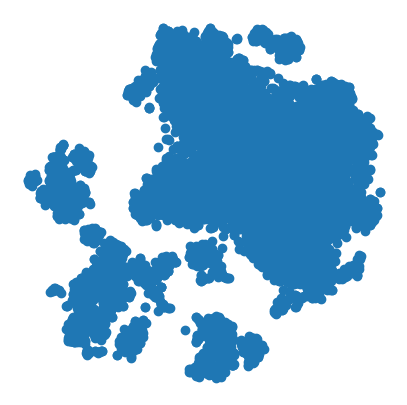

Figure: the 2D projection of the ~70-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [0]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
pl.figure(figsize=(5,5))
pl.scatter(X_embedded[:,0], X_embedded[:,1])
pl.axis('off')
pl.show()

Figure: the 2D projection of the ~80-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. I can see four clusters in this plot.

Colorizing the TSNE

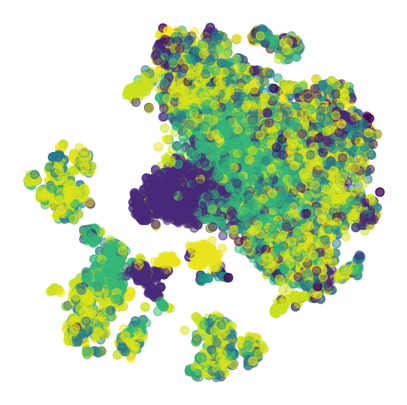

In [0]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in pl.cm.RdBu_r(norm_obj(y))]), X_embedded.shape
pl.figure(figsize=(5,5))
pl.axis('off')
pl.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in pl.cm.viridis(norm_obj(y))], alpha=0.5);

Figure: The purity of the sample is not good in the t-SNE projection against the target variable. The colors are mixed in this t-SNE clusters, the highest purity is achieved near the center of the projected feature space. This is not a particularly promising situation.

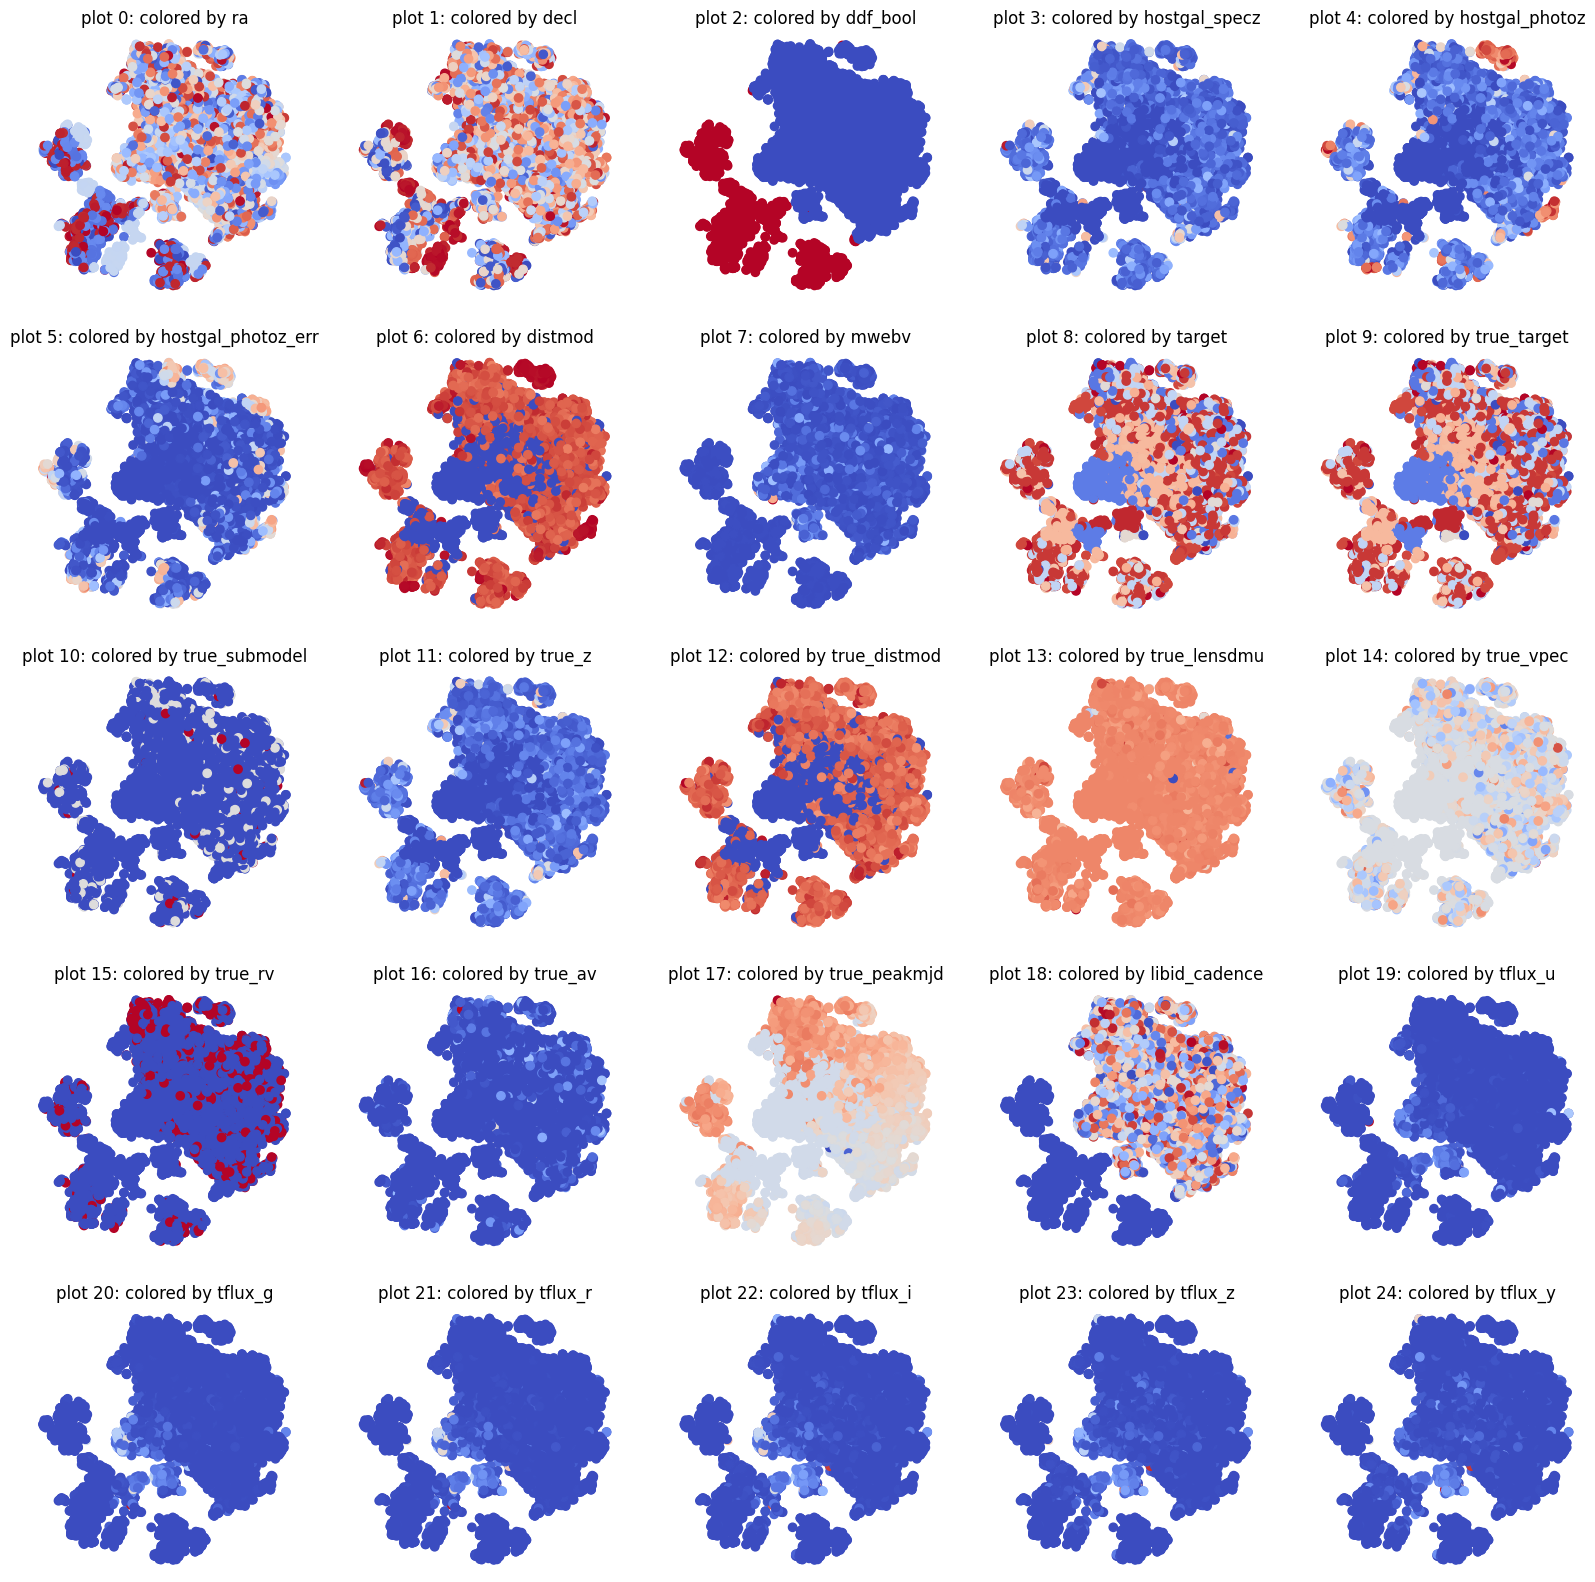

In [0]:
fig = pl.figure(figsize=(20,20))
# note: I am avoiding the first column of metadata which is the object identifier
for i, col in enumerate(metadata.columns[1:]):
    ax = fig.add_subplot(5,5,i+1)
    v = metadata[col].astype(float)
    ax.set_title("plot %d: colored by %s"%(i,col))
    ax.scatter(X_embedded[:,0], X_embedded[:,1],  
               color=[pl.cm.coolwarm(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])
    ax.axis('off')

    #pl.show()

Figure : The feature space is projected on a 2D plane via t-SNE method, and the points are colorcoded by the value of all metadata: this includes features used in the feature space as well as features that are not used in the feature space. The fueature space t-SNE projection does not map the metadata, except for the survey: row 1 and column 3 the data includes a DeepDrillingField survey and a regular survey (called wide-fast-deep) which include different observation strategy decisions (data collection strategy). Those are obviously affecting the data features this the clear split of the cluster in row 1 column 3. (The deep drilling fields are special regions of the sky that would be observed more frequently, a whole bunch of times in one night. So even if an object were the same kind of object the extracted features could be very different!).

Most other features map the t-SNE projection more poorly.


**==> missing the discussion**

# PART IIA.2: Clustering

##Cluster the data using Agglomerative and DBscan

In [0]:
from sklearn.cluster import AgglomerativeClustering

I can use the Eucledian distance because I preprocessed the feature space and all features have the same standard deviation!

elements in cluster 0 5814
elements in cluster 1 1
elements in cluster 2 2033



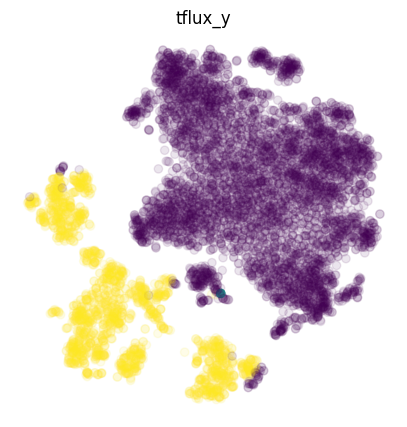

Figure: clustering the 75 dimensional feature space based on Agglomerateive Clustering algorithm with Eucledian distance into 3 clustersThere are 2 clusters of several observations, mapping excellently to the t-SNE projectionOne cluster of one indicates the presence of an outlier


In [0]:
clustering = AgglomerativeClustering(n_clusters=3).fit(X_scaled)

for j in range(3):
    print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
print()
pl.figure(figsize=(5,5))
pl.title(col)

#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                                                         for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()

Figure: Clustering the 83 dimensional feature space based on Agglomerateive Clustering algorithm with Eucledian distance into 3 clusters There are 2 clusters of several observations, mapping excellently to the t-SNE projection One cluster of one indicates the presence of an outlier.

# Part IIA.3: Using AgglomerativeClustering in sklearn allows to select the number of cluster, run AgglomearativeCLustering with 2,3,4,5,6 clusters with Eucledian distance.

elements in cluster 0 7847
elements in cluster 1 1



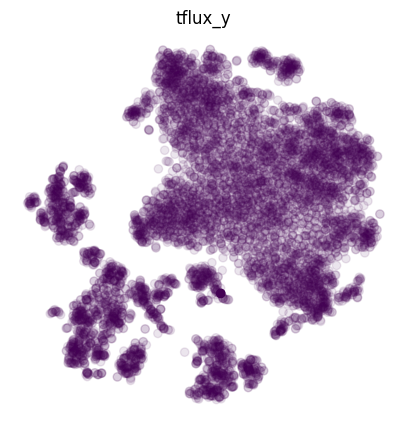

elements in cluster 0 5814
elements in cluster 1 1
elements in cluster 2 2033



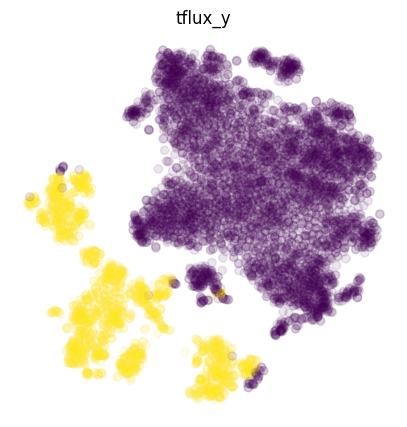

elements in cluster 0 5813
elements in cluster 1 1
elements in cluster 2 2033
elements in cluster 3 1



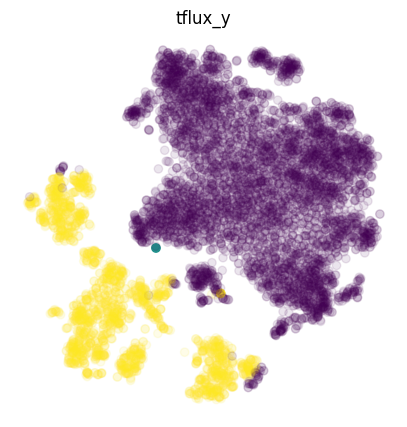

elements in cluster 0 4598
elements in cluster 1 1215
elements in cluster 2 2033
elements in cluster 3 1
elements in cluster 4 1



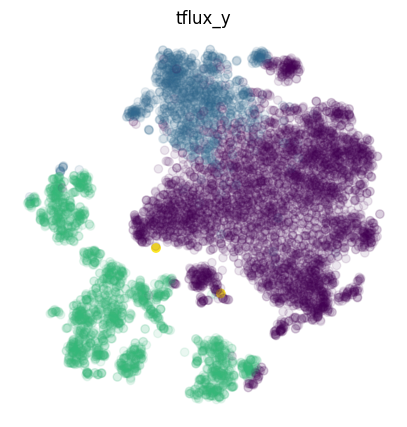

In [0]:
for n in range(2,6):
    '''
    clustering using AgglomerativeClustering with 2,3,4,5,6 clusters with
    Eucledian diatance since we normalized
    '''
    clustering = AgglomerativeClustering(n_clusters=n).fit(X_scaled)
    for j in range(n):
        print("elements in cluster {} {}".format(j, (clustering.labels_ == j).sum()))
    print()
    pl.figure(figsize=(5,5))
    pl.title(col)

    #using a color map normalized according to the number of clusters:
    # for 3 clusters vmin=0, vmax=2
    colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=j-1)(c))
                                                         for c in clustering.labels_])
    # changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
    alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 2 else 1.0 for j in clustering.labels_])
    # setting the alpha channel by replacing the default of the colormap which is 1
    colors[:,3] = alpha
    
    pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
                color=colors);
    pl.axis('off')
    pl.show()

Figure: Clustering the 83 dimensional feature space based on Agglomerateive clustering algorithm with Eucledian distance into various cluster sizes ranging from 2 to 5. For the n=2 cluster cases, there is one outlier, whereas for all the other cases, there are always at there are multiple ouliers.

# Part IIA.4: What happens if I change the distance metric?

1. Create a new metric: precompute the braycurtis metric with scipy.spatial.distance.cdist and pass it to the accolmerative clustering with n_clusters=3 and affinity='precomputed'. Describe the result. Look online, on the documentation of scipy and on the any statistical resources (wikipedia has great pages on this) to describe the braycurtis distance.

In [0]:
from scipy.spatial.distance import cdist

In [0]:
dist = cdist(X_scaled, X_scaled, metric='braycurtis')
clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', 
                                    linkage="complete").fit(dist)
for j in range(2, -1, -1):
        print("elements in cluster {} {}"\
              .format(j, (clustering.labels_ == j).sum()))

elements in cluster 2 2861
elements in cluster 1 2402
elements in cluster 0 2585


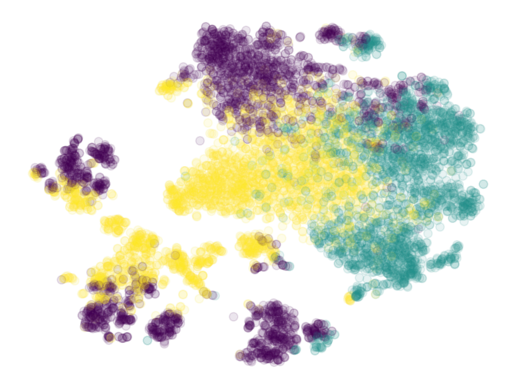

In [0]:
#using a color map normalized according to the number of clusters:
# for 3 clusters vmin=0, vmax=2
colors = np.array([pl.cm.viridis(Normalize(vmin=0, vmax=2)(c))
                  for c in clustering.labels_])
# changing the alpha (transparency) based on the number of objects in the cluster or some clusters would not be visible
alpha = np.array([0.1 if (clustering.labels_ == j).sum() > 200 else 1.0 for j in clustering.labels_])
# setting the alpha channel by replacing the default of the colormap which is 1
colors[:,3] = alpha
    
pl.scatter(X_embedded[:,0], X_embedded[:,1], # alpha = alpha,
               color=colors);
pl.axis('off')
pl.show()



**==> missing the discussion**

# what have we learned?...

## This was actually very helpful to understand that there are 2 surveys which split into 2 cluster under most cluster parameter choices. Other than that... I am not sure. And this happens a lot to me with clustering to be frank.

1. In many cases above (e.g. AgglomerativeClustering(n_clusters=3).fit(X_scaled)) the clustring reflected a split that was obvious in the t-SNE visualization of the feature space: a large cluster on the top right of my plot, a more diffuse and structured cluster in the bottom left. This splits the deep drilling fields observations from the regular survey observations. It is good and it makes sense that we get that split, but it is not particularly insightful scientifically cause it tells us about the kind of observations we did, not the nature of the objects.

2. In some cases clusters of one (in the Agglomarative clustering) or outliers are identified (DBscan) but in a 79-dimensioanl parameter space it is hard to see what that really means... why is a "outlier" different? In fact this challenge was purposefully designed to have no outliers in the training set (which is what we used) and have outliers in the test set. So our "outliers" should not be outliers. And if we change the parameters in the DBscan they are clustering changes indeed!



# PARTH IIB: Classifying

Unlike clustering, classifying requires the existance of examples - we are learning by example how to spli tobervations among classes. We already prepared the train and test samples.

Notice that tree methods do not require scaling or whitening! Why? because they deal with each feature one by one, so they make no assumption about covariance of features (until you try to do feature importance) you can use the original X for the tree-based classification

## TASK IIB.1: We will treat the 2 surveys separately: the general survey, and the deep drilling fields

In [0]:
print("breakdown between surveys {} {}".format(
    (metadata.ddf_bool == 1).sum(), (metadata.ddf_bool == 0).sum()))

breakdown between surveys 2116 5732


In [0]:
X = allfeatures.iloc[:,:-1].values
y = allfeatures.iloc[:,-1].values

Xddf = X[allfeatures.ddf_bool==1]
Xnormal = X[allfeatures.ddf_bool==0]
yddf =  y[allfeatures.ddf_bool==1]
ynormal =  y[allfeatures.ddf_bool==0]

In [0]:
import sklearn
from sklearn.model_selection import train_test_split

X_trainddf, X_testddf, y_trainddf, y_testddf = \
            train_test_split(Xddf, yddf, test_size=0.33, 
                             random_state=42, shuffle=True)

X_trainnormal, X_testnormal, y_trainnormal, y_testnormal = \
            train_test_split(Xnormal, ynormal, test_size=0.33, 
                             random_state=42, shuffle=True)

## Part IIB.2: Classification with Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clfddf = RandomForestClassifier(n_estimators=100, 
                criterion='gini', max_depth=5).fit(X_trainddf, y_trainddf)
clfnormal = RandomForestClassifier(n_estimators=100, 
                criterion='gini', max_depth=5).fit(X_trainnormal, y_trainnormal)



In [0]:
print("Random Forest Classification\n" + 
       "score on DDF {:.2f} and on normal survey {:.2f}".format(
           clfddf.score(X_testddf, y_testddf),
           clfnormal.score(X_testnormal, y_testnormal)))

Random Forest Classification
score on DDF 0.74 and on normal survey 0.61


This is the value on quality of the split using the classifier

**==>missing the GBT part**

# Part IIB.3: Because this is a classification problem, we can build a confusion matrix

Confusion matrix, without normalization
Normalized confusion matrix


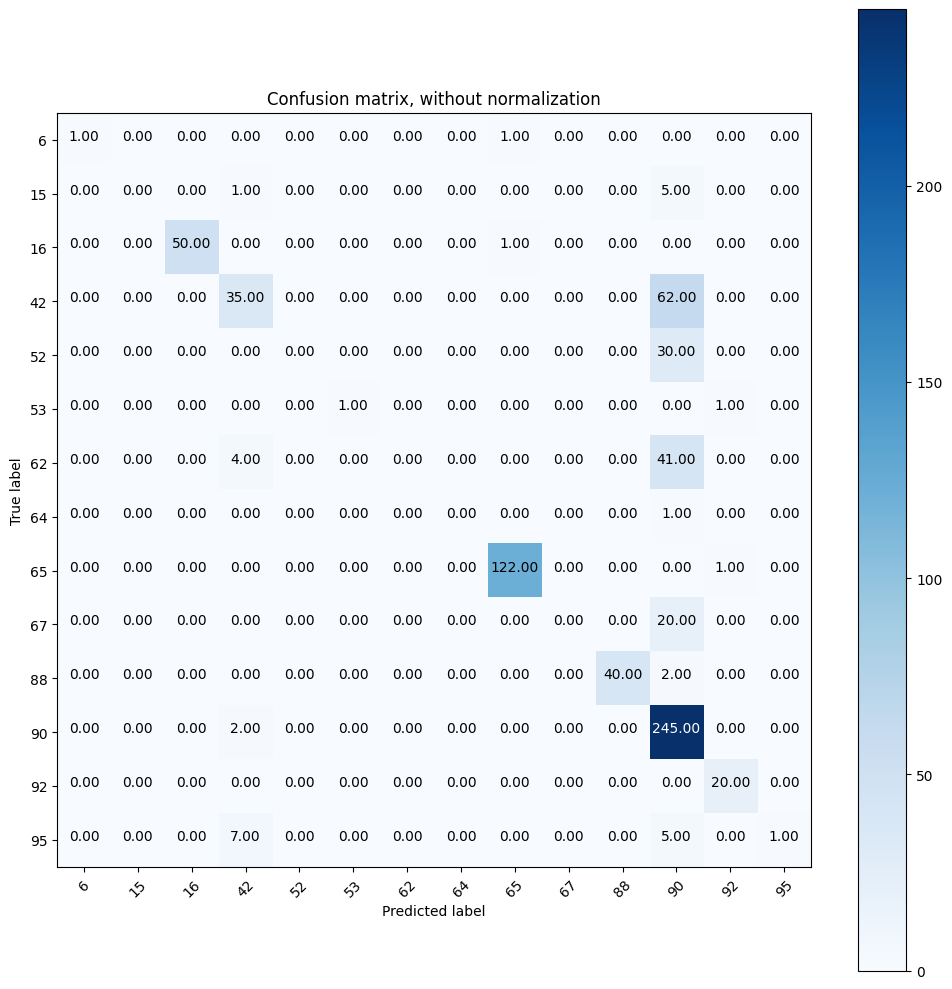

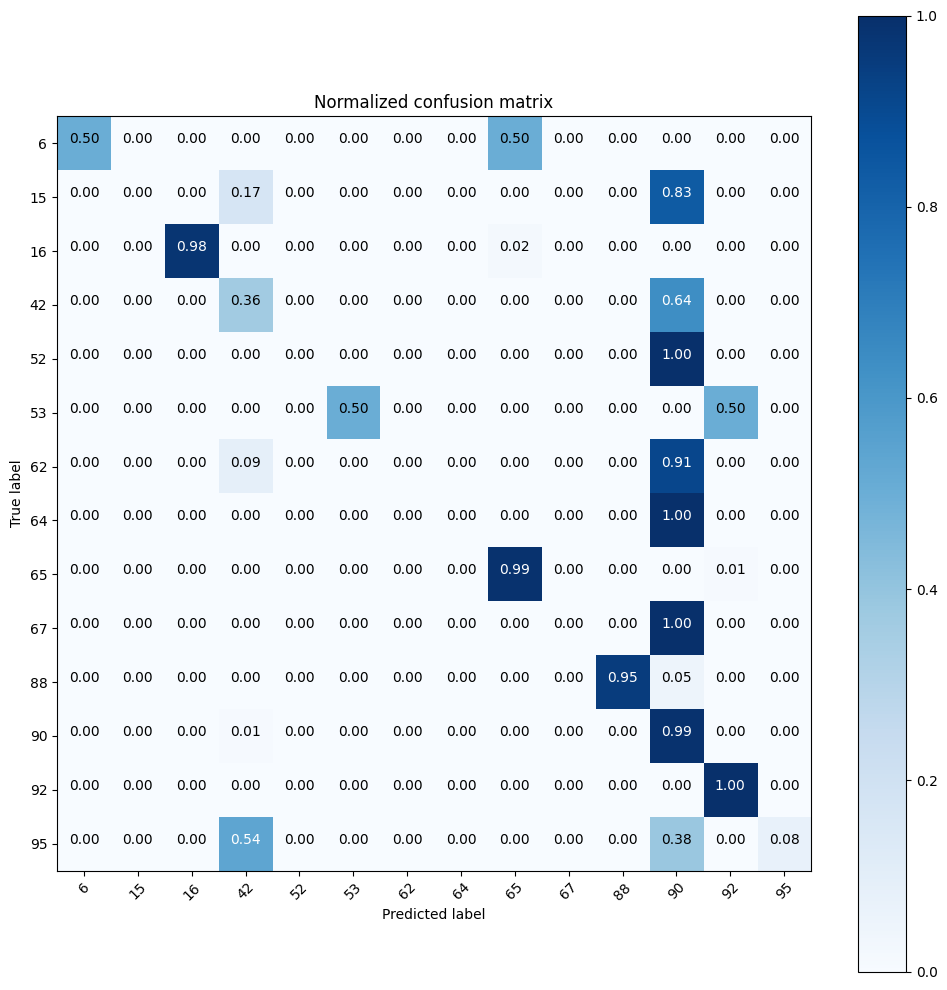

In [0]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_testddf, clfddf.predict(X_testddf))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


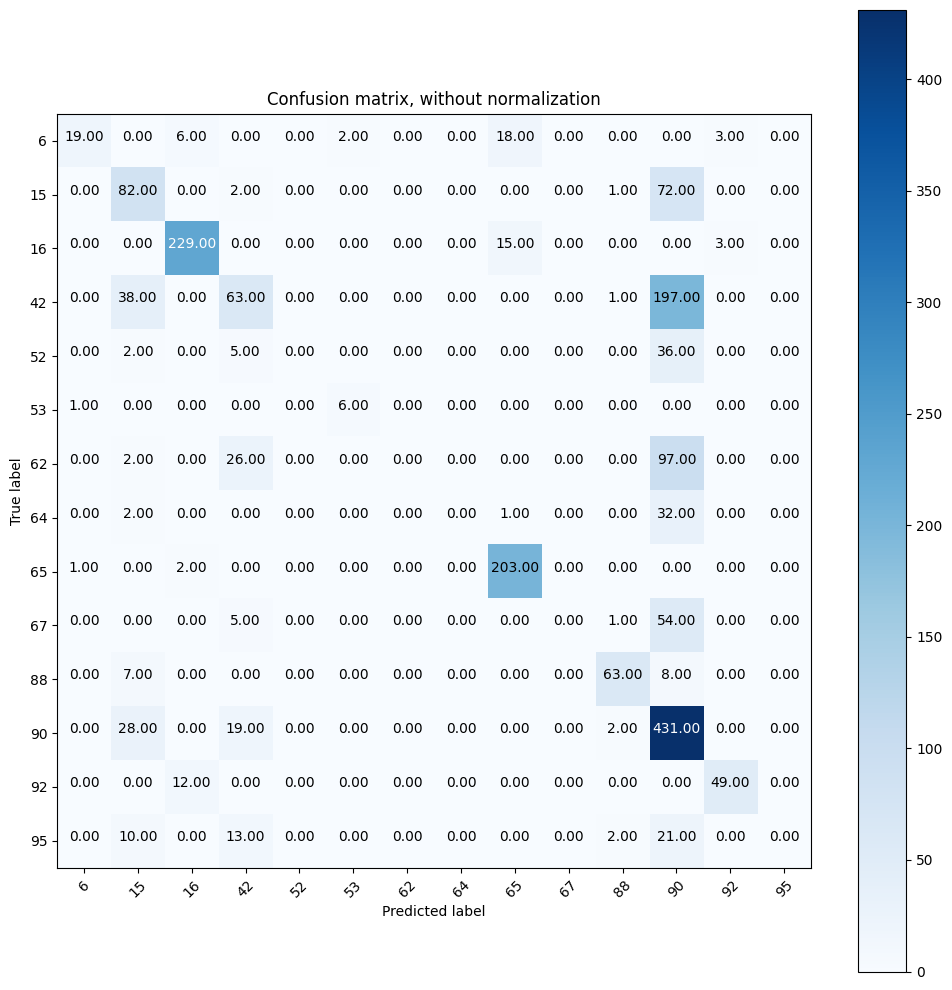

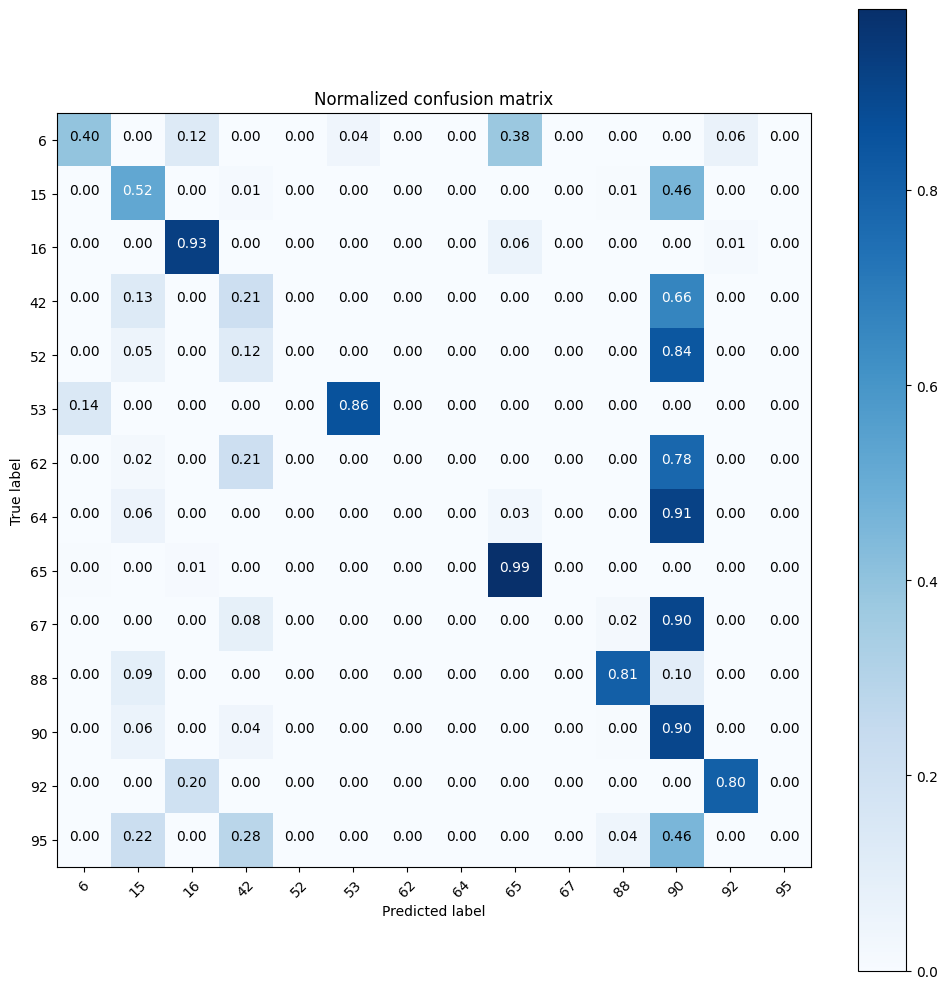

In [0]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_testnormal, clfnormal.predict(X_testnormal))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()



Confusion matrix shows how sucessfull the classifier has been able to distinguish each feature against each other, heigher score on the diagonal means all the data of that features are together. Heigher values on off diagonal implies there is still some mixing which we couldn't still distinct